In [92]:
import tensorflow as tf
###OG Paper https://www.frontiersin.org/articles/10.3389/fncom.2020.00009/full

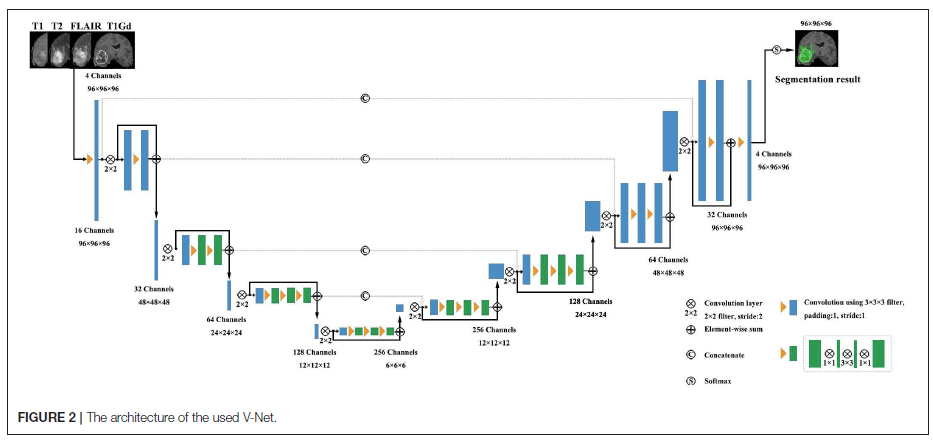


In [82]:
def input_conv_block(inputs, filters, kernel_size=3, activation=True):
    x= tf.keras.layers.Conv3D(filters, kernel_size=kernel_size, strides=1, padding="same", 
                                 kernel_initializer="he_normal")(inputs)
    x= tf.keras.layers.BatchNormalization()(x)
    if activation is True:
        x= tf.keras.layers.Activation("relu")(x)
    else:
        x= tf.keras.layers.Activation("softmax")(x)
        
    return x
    

In [83]:
def conv_block_blue(inputs, filters, num_reps, activation=False):
    x = inputs
    for _ in range(num_reps):
        x = tf.keras.layers.Conv3D(filters, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if activation is False:
            break
        else:
            x = tf.keras.layers.Activation("relu")(x)
        activation = False
    x = tf.keras.layers.add([x, inputs])
    x = tf.keras.layers.Activation("relu")(x)
    return x

In [84]:
def conv_block(inputs, filters):
    x= tf.keras.layers.Conv3D(filters, kernel_size=1, strides=1, padding="same", 
                                 kernel_initializer="he_normal")(inputs)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation("relu")(x)
    
    x= tf.keras.layers.Conv3D(filters, kernel_size=3, strides=1, padding="same", 
                                 kernel_initializer="he_normal")(x)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation("relu")(x)
    
    x= tf.keras.layers.Conv3D(filters, kernel_size=1, strides=1, padding="same", 
                                 kernel_initializer="he_normal")(x)
    x= tf.keras.layers.BatchNormalization()(x)
    
    return x
    

In [85]:
def conv_block_green(inputs, filters, num_reps, activation):
    x= inputs
    y= conv_block(x, filters)
    y= tf.keras.layers.Activation("relu")(y)
    for _ in range(num_reps-1):
        y = conv_block(y, filters)
        if activation is True:
            y= tf.keras.layers.Activation("relu")(y)
        
            activation = False
    x = tf.keras.layers.add([x, y])
    x = tf.keras.layers.Activation("relu")(x)
    return x

In [86]:
def down_block(inputs, filters):
    x=tf.keras.layers.Conv3D(filters, kernel_size=2, strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation("relu")(x)
    return x
    

In [87]:
def up_block(inputs, filters):
    x=tf.keras.layers.Conv3DTranspose(filters, kernel_size=2, strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x= tf.keras.layers.BatchNormalization()(x)
    x= tf.keras.layers.Activation("relu")(x)
    return x

In [90]:
def VNet(num_classes=4):
    inputs= tf.keras.layers.Input(shape=(128, 128, 128, num_classes))
    x_1= input_conv_block(inputs, filters=16)
    
    x= down_block(x_1, filters=32) ##down 1
    
    x_2= conv_block_blue(x, filters=32, num_reps=1)
    
    x= down_block(x_2, filters= 64) ##down 2
    
    x_3= conv_block_green(x, filters= 64, num_reps=2, activation=False)
    
    x= down_block(x_3, filters= 128) ##down 3
    
    x_4= conv_block_green(x, filters= 128, num_reps=3, activation=True)
    
    x= down_block(x_4, filters=256) ##down 4
    
    x= conv_block_green(x, filters= 256, num_reps=3, activation=True)
    
    up_1= up_block(x, filters=128) ##up 1
    
    cat= tf.keras.layers.concatenate([up_1, x_4])
    
    x= conv_block_green(cat, filters= 256, num_reps=3, activation=True)
    
    up_2= up_block(x, filters=64) ##up 2
    
    cat= tf.keras.layers.concatenate([up_2, x_3])
    
    x= conv_block_green(cat, filters= 128, num_reps=3, activation=True)
    
    up_3= up_block(x, filters=32) ##up 3
    
    cat= tf.keras.layers.concatenate([up_3, x_2])
    
    x= conv_block_blue(cat, filters= 64, num_reps=2, activation=True)
    
    up_4= up_block(x, filters=16) ##up 4
    
    cat= tf.keras.layers.concatenate([up_4, x_1])
    
    x= conv_block_blue(cat, filters= 32, num_reps=1)
    
    x= input_conv_block(x, filters=num_classes, kernel_size=1, activation= False)
    
    output=x
    return tf.keras.Model(inputs=inputs, outputs=output)

In [91]:
model= VNet()
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d_920 (Conv3D)            (None, 128, 128, 12  1744        ['input_21[0][0]']               
                                8, 16)                                                            
                                                                                                  
 batch_normalization_983 (Batch  (None, 128, 128, 12  64         ['conv3d_920[0][0]']             
 Normalization)                 8, 16)                                                     

                                                                                                  
 batch_normalization_991 (Batch  (None, 32, 32, 32,   256        ['conv3d_928[0][0]']             
 Normalization)                 64)                                                               
                                                                                                  
 activation_975 (Activation)    (None, 32, 32, 32,   0           ['batch_normalization_991[0][0]']
                                64)                                                               
                                                                                                  
 conv3d_929 (Conv3D)            (None, 32, 32, 32,   4160        ['activation_975[0][0]']         
                                64)                                                               
                                                                                                  
 batch_nor

                                128)                                                              
                                                                                                  
 batch_normalization_1000 (Batc  (None, 16, 16, 16,   512        ['conv3d_937[0][0]']             
 hNormalization)                128)                                                              
                                                                                                  
 activation_984 (Activation)    (None, 16, 16, 16,   0           ['batch_normalization_1000[0][0]'
                                128)                             ]                                
                                                                                                  
 conv3d_938 (Conv3D)            (None, 16, 16, 16,   442496      ['activation_984[0][0]']         
                                128)                                                              
          

                                                                                                  
 conv3d_946 (Conv3D)            (None, 8, 8, 8, 256  65792       ['activation_992[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_1009 (Batc  (None, 8, 8, 8, 256  1024       ['conv3d_946[0][0]']             
 hNormalization)                )                                                                 
                                                                                                  
 activation_993 (Activation)    (None, 8, 8, 8, 256  0           ['batch_normalization_1009[0][0]'
                                )                                ]                                
                                                                                                  
 conv3d_94

 batch_normalization_1017 (Batc  (None, 16, 16, 16,   1024       ['conv3d_953[0][0]']             
 hNormalization)                256)                                                              
                                                                                                  
 activation_1001 (Activation)   (None, 16, 16, 16,   0           ['batch_normalization_1017[0][0]'
                                256)                             ]                                
                                                                                                  
 conv3d_954 (Conv3D)            (None, 16, 16, 16,   1769728     ['activation_1001[0][0]']        
                                256)                                                              
                                                                                                  
 batch_normalization_1018 (Batc  (None, 16, 16, 16,   1024       ['conv3d_954[0][0]']             
 hNormaliz

                                128)                             ]                                
                                                                                                  
 conv3d_961 (Conv3D)            (None, 32, 32, 32,   16512       ['activation_1009[0][0]']        
                                128)                                                              
                                                                                                  
 batch_normalization_1026 (Batc  (None, 32, 32, 32,   512        ['conv3d_961[0][0]']             
 hNormalization)                128)                                                              
                                                                                                  
 activation_1010 (Activation)   (None, 32, 32, 32,   0           ['batch_normalization_1026[0][0]'
                                128)                             ]                                
          

                                                                                                  
 batch_normalization_1034 (Batc  (None, 64, 64, 64,   256        ['conv3d_968[0][0]']             
 hNormalization)                64)                                                               
                                                                                                  
 activation_1018 (Activation)   (None, 64, 64, 64,   0           ['batch_normalization_1034[0][0]'
                                64)                              ]                                
                                                                                                  
 conv3d_969 (Conv3D)            (None, 64, 64, 64,   110656      ['activation_1018[0][0]']        
                                64)                                                               
                                                                                                  
 batch_nor